In [1]:
import pandas as pd

# Load data from CSV file
data = pd.read_csv('../data/sentinelTestsDetectionsPositivity.csv')

# Display the first few rows of the dataframe
display(data.head())
display(data['countryname'].unique())
display(data['indicator'].unique())

,survtype,countryname,yearweek,pathogen,pathogentype,pathogensubtype,indicator,age,value
0,primary care sentinel,Austria,2025-W12,Influenza,Influenza,total,detections,total,46.0
1,primary care sentinel,Austria,2025-W12,Influenza,Influenza,total,positivity,total,18.9
2,primary care sentinel,Austria,2025-W12,Influenza,Influenza,total,tests,total,244.0
3,primary care sentinel,Austria,2025-W12,Influenza,Influenza A,A (unknown),detections,total,1.0
4,primary care sentinel,Austria,2025-W12,Influenza,Influenza A,A(H1)pdm09,detections,total,14.0


array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'EU/EEA', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden'], dtype=object)

array(['detections', 'positivity', 'tests'], dtype=object)

In [2]:
from datetime import datetime

def yearweek_to_date(yearweek):
    # Split year and week
    year = int(yearweek.split('-W')[0])
    week = int(yearweek.split('-W')[1])
    
    # Create a date object for the Monday of that week
    # %G: ISO year, %V: ISO week number
    date = datetime.strptime(f'{year}-W{week:02d}-1', '%G-W%V-%w')
    return date.strftime('%Y-%m-%d')

# Add new date column to weekly_pathogen
data['date'] = data['yearweek'].apply(yearweek_to_date)

# Sort by date
data = data.sort_values('date')

# Display the first few rows to verify the conversion
display(data.head())

,survtype,countryname,yearweek,pathogen,pathogentype,pathogensubtype,indicator,age,value,date
47751,primary care sentinel,Sweden,2020-W25,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,tests,total,40.0,2020-06-15
34693,primary care sentinel,Netherlands,2020-W25,Influenza,Influenza,total,positivity,total,0.0,2020-06-15
34694,primary care sentinel,Netherlands,2020-W25,Influenza,Influenza,total,tests,total,4.0,2020-06-15
34695,primary care sentinel,Netherlands,2020-W25,RSV,RSV,RSV,detections,total,0.0,2020-06-15
34696,primary care sentinel,Netherlands,2020-W25,RSV,RSV,RSV,positivity,total,0.0,2020-06-15


In [3]:
# Filter for global data for the main Influenza type (ignoring subtypes)
influenza_global_raw = data[(data['pathogen'] == 'Influenza') & (data['pathogentype'] == 'Influenza')]

# Group by week and indicator, then sum the values
influenza_global = influenza_global_raw.groupby(['date', 'indicator'])['value'].sum().unstack()

# Compute positivity: detections / tests
influenza_global['positivity'] = influenza_global['detections'] / influenza_global['tests']

# Display the resulting DataFrame
display(influenza_global)




indicator,detections,positivity,tests
date,,,
2020-06-15,0.0,0.000000,98.0
2020-06-22,0.0,0.000000,94.0
2020-06-29,0.0,0.000000,132.0
2020-07-06,0.0,0.000000,92.0
2020-07-13,0.0,0.000000,92.0
...,...,...,...
2025-02-24,3094.0,0.330697,9356.0
2025-03-03,2376.0,0.298567,7958.0
2025-03-10,2124.0,0.283351,7496.0


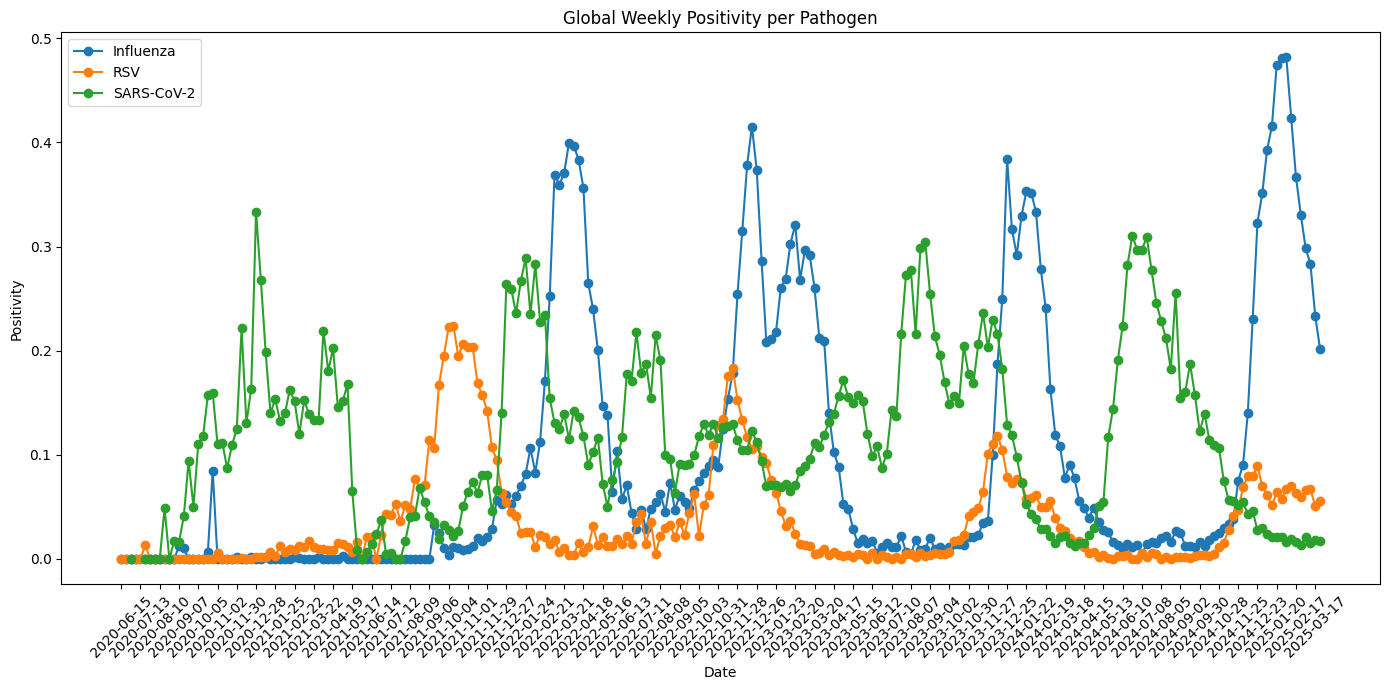

In [ ]:
import matplotlib.pyplot as plt

# Select only rows where the main pathogen type is used (i.e. pathogen == pathogentype)
main_global_raw = data[data['pathogen'] == data['pathogentype']]

# Group by week, pathogen, and indicator, then sum the values
main_global = main_global_raw.groupby(['date', 'pathogen', 'indicator'])['value'].sum().unstack('indicator')

# Compute positivity for each pathogen and week (detections / tests)
main_global['positivity'] = main_global['detections'] / main_global['tests']

# Reset index for plotting convenience
main_global = main_global.reset_index()

# Plot positivity over time for each pathogen
fig, ax = plt.subplots(figsize=(14, 7))
for pathogen, grp in main_global.groupby('pathogen'):
    ax.plot(grp['date'], grp['positivity'], marker='o', label=pathogen)

ax.set_xlabel('Date')
ax.set_ylabel('Positivity')
ax.set_title('Global Weekly Positivity per Pathogen')

# Get current tick positions and labels
ticks = ax.get_xticks()
labels = ax.get_xticklabels()

# Show fewer ticks, evenly distributed
n_ticks = len(labels) // 4
step = len(labels) // n_ticks
ax.set_xticks(ticks[::step])
ax.set_xticklabels(labels[::step], rotation=45)

ax.legend()
plt.tight_layout()
plt.show()

In [20]:
data.pathogentype.unique()


array(['SARS-CoV-2', 'Influenza', 'RSV', 'RSV untyped', 'Influenza B',
       'Influenza A', 'Influenza untyped', 'RSV-B', 'RSV-A'], dtype=object)

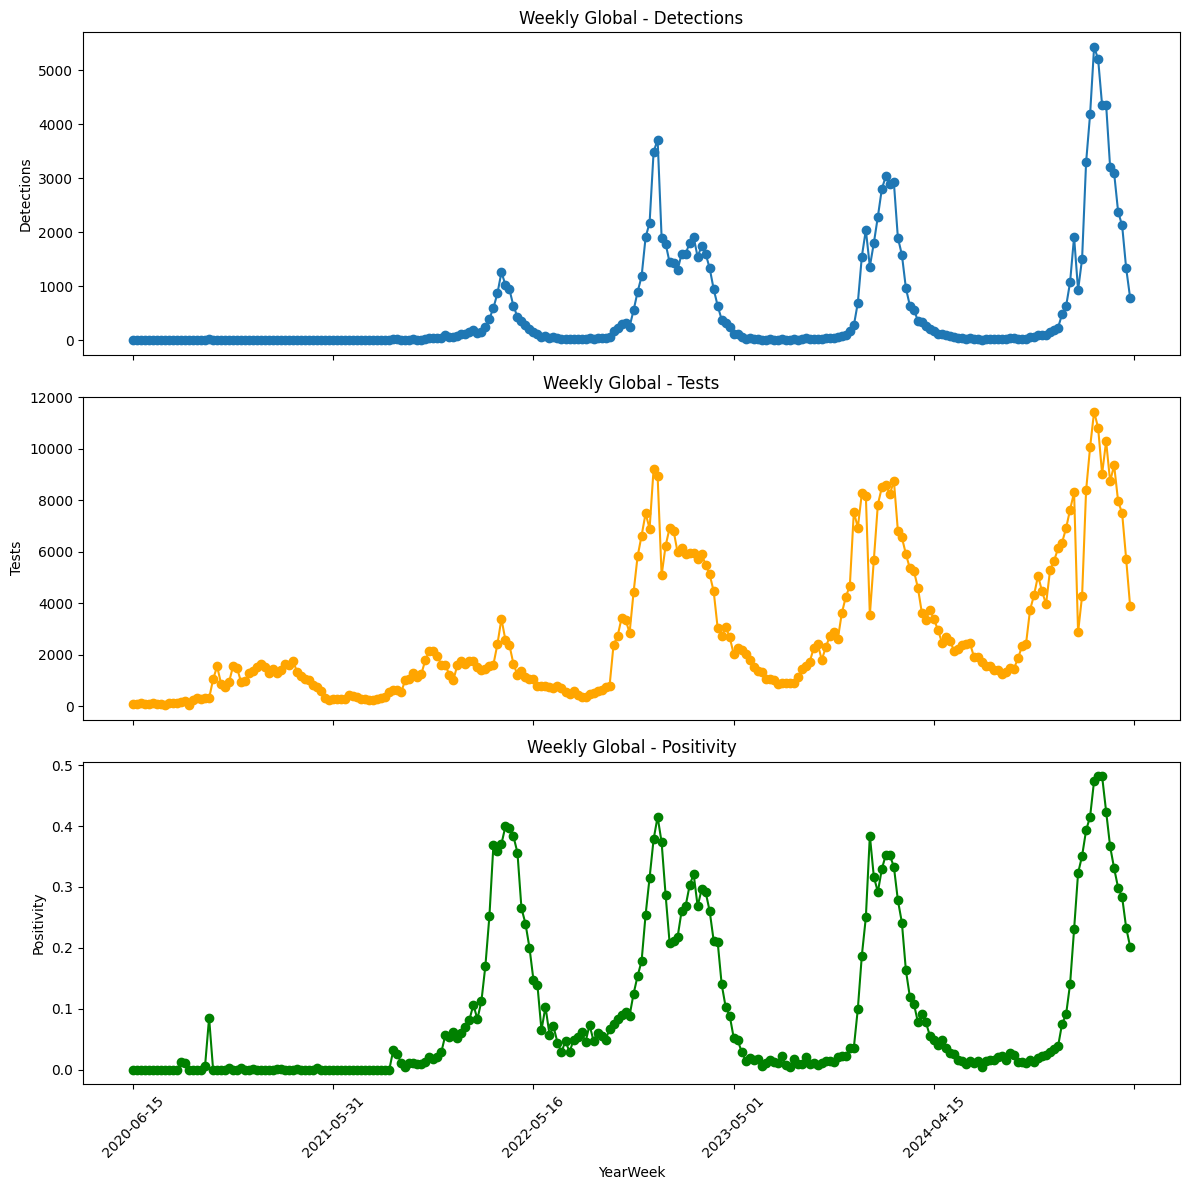

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for each indicator
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

influenza_global['detections'].plot(ax=axes[0], marker='o', title='Weekly Global - Detections')
axes[0].set_ylabel('Detections')

influenza_global['tests'].plot(ax=axes[1], marker='o', color='orange', title='Weekly Global - Tests')
axes[1].set_ylabel('Tests')

influenza_global['positivity'].plot(ax=axes[2], marker='o', color='green', title='Weekly Global - Positivity')
axes[2].set_ylabel('Positivity')

plt.xlabel('YearWeek')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()